In [ ]:
# ================================================================
# CLEAN IMPORTS 
# ================================================================
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Sklearn modules
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)


In [2]:
# ================================================================
# PHASE 1: DATA COLLECTION AND PREPARATION
# Tasks 1.1 - 1.4
# ================================================================


file_path ="C:\\Users\\USER\\Desktop\\Testing\\Churning\\Churning.csv"                 # change this if your dataset is in another folder
        # cleaned dataset will be saved here
out_path  = "Churning_cleaned.csv"   


In [3]:
# 1. Load dataset
print("Step 1: Loading dataset...")
df = pd.read_csv(file_path)
print(" - Loaded successfully! Shape:", df.shape)

Step 1: Loading dataset...
 - Loaded successfully! Shape: (7043, 21)


In [4]:
# 2. Preview data
print("\nStep 2: First 5 rows of dataset:")
print(df.head())


Step 2: First 5 rows of dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV St

In [5]:
# 3. Dataset info
print("\nStep 3: Data types and non-null counts:")
print(df.info())


Step 3: Data types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  P

In [6]:
# 4. Check missing values
print("\nStep 4: Missing values per column:")
print(df.isnull().sum().sort_values(ascending=False))


Step 4: Missing values per column:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [7]:
# 5. Check for empty strings (hidden blanks in text columns)
print("\nStep 5: Empty-string counts in object columns:")
empty_strings = df.select_dtypes(include='object').apply(
    lambda x: x.str.strip().eq('').sum()
)
print(empty_strings[empty_strings > 0])


Step 5: Empty-string counts in object columns:
TotalCharges    11
dtype: int64


In [8]:
# 6. Check TotalCharges for invalid entries
print("\nStep 6: Checking invalid TotalCharges values...")
non_numeric_tc = pd.to_numeric(df['TotalCharges'], errors='coerce').isnull()
print(" - Count of non-numeric TotalCharges:", non_numeric_tc.sum())
print(df.loc[non_numeric_tc, ['customerID','tenure','MonthlyCharges','TotalCharges']].head(10))


Step 6: Checking invalid TotalCharges values...
 - Count of non-numeric TotalCharges: 11
      customerID  tenure  MonthlyCharges TotalCharges
488   4472-LVYGI       0           52.55             
753   3115-CZMZD       0           20.25             
936   5709-LVOEQ       0           80.85             
1082  4367-NUYAO       0           25.75             
1340  1371-DWPAZ       0           56.05             
3331  7644-OMVMY       0           19.85             
3826  3213-VVOLG       0           25.35             
4380  2520-SGTTA       0           20.00             
5218  2923-ARZLG       0           19.70             
6670  4075-WKNIU       0           73.35             


In [9]:
# 7. Check duplicates and churn distribution
print("\nStep 7: Duplicate rows:", df.duplicated().sum())
print("\nStep 8: Churn distribution:")
print(df['Churn'].value_counts())



Step 7: Duplicate rows: 0

Step 8: Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [10]:
# ================================================================
# CLEANING STEPS
# ================================================================

print("\n--- Cleaning data ---")

# A) Remove extra spaces from column names and text values
df.columns = df.columns.str.strip()
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()
print("A) Stripped spaces from text columns.")


--- Cleaning data ---
A) Stripped spaces from text columns.


In [11]:

# B) Convert TotalCharges to numeric and fix missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("B) Converted TotalCharges to numeric. NaN count:", df['TotalCharges'].isnull().sum())

B) Converted TotalCharges to numeric. NaN count: 11


In [12]:
# If TotalCharges is NaN (usually when tenure = 0), fill using MonthlyCharges * tenure
mask_nan = df['TotalCharges'].isnull()
if mask_nan.any():
    df.loc[mask_nan, 'TotalCharges'] = df.loc[mask_nan, 'MonthlyCharges'] * df.loc[mask_nan, 'tenure']
    df['TotalCharges'].fillna(0, inplace=True)
    print("   -> Filled NaN TotalCharges values.")

   -> Filled NaN TotalCharges values.


C:\Users\USER\AppData\Local\Temp\ipykernel_7660\3889871269.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(0, inplace=True)


In [13]:
# C) Replace 'No internet service' and 'No phone service' with 'No'
df.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)
print("C) Replaced 'No internet service' & 'No phone service' with 'No'.")


C) Replaced 'No internet service' & 'No phone service' with 'No'.


In [14]:
# D) Drop customerID column
if 'customerID' in df.columns:
    df.drop('customerID', axis=1, inplace=True)
    print("D) Dropped customerID column.")

D) Dropped customerID column.


In [15]:
# E) Encode Churn: No -> 0, Yes -> 1
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})
print("E) Encoded Churn column to 0/1.")

E) Encoded Churn column to 0/1.


In [16]:
# F) Convert remaining text columns to category
obj_cols = df.select_dtypes(include='object').columns.tolist()
for col in obj_cols:
    df[col] = df[col].astype('category')
print("F) Converted object columns to category:", obj_cols)

F) Converted object columns to category: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [17]:
# ================================================================
# FINAL CHECKS
# ================================================================
print("\n--- Final Checks ---")
print("Shape after cleaning:", df.shape)
print("\nMissing values (should be zero):")
print(df.isnull().sum().sort_values(ascending=False))
print("\nData types:")
print(df.dtypes)
print("\nFirst 5 rows of cleaned dataset:")
print(df.head())

# Save cleaned file
df.to_csv(out_path, index=False)
print("\n✅ Cleaned dataset saved to:", out_path)


--- Final Checks ---
Shape after cleaning: (7043, 20)

Missing values (should be zero):
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Data types:
gender              category
SeniorCitizen          int64
Partner             category
Dependents          category
tenure                 int64
PhoneService        category
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessB

In [18]:

# ================================================================
# PHASE 2: EXPLORATORY DATA ANALYSIS (EDA)
# Tasks 2.1 - 2.3 (+ correlation analysis)
# ================================================================


# Load cleaned dataset from Phase 1
file_path = "Churning_cleaned.csv"   # make sure Phase 1 saved this
df = pd.read_csv(file_path)

print("Dataset loaded for EDA. Shape:", df.shape)

Dataset loaded for EDA. Shape: (7043, 20)


In [19]:
# ------------------------------------------------
# 2.1: General exploration
# ------------------------------------------------
print("\nStep 2.1: Basic dataset info")
print(df.info())

print("\nSummary statistics for numerical features:")
print(df.describe())

print("\nChurn distribution (target variable):")
print(df['Churn'].value_counts(normalize=True))


Step 2.1: Basic dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMetho


Step 2.2: Generating plots...


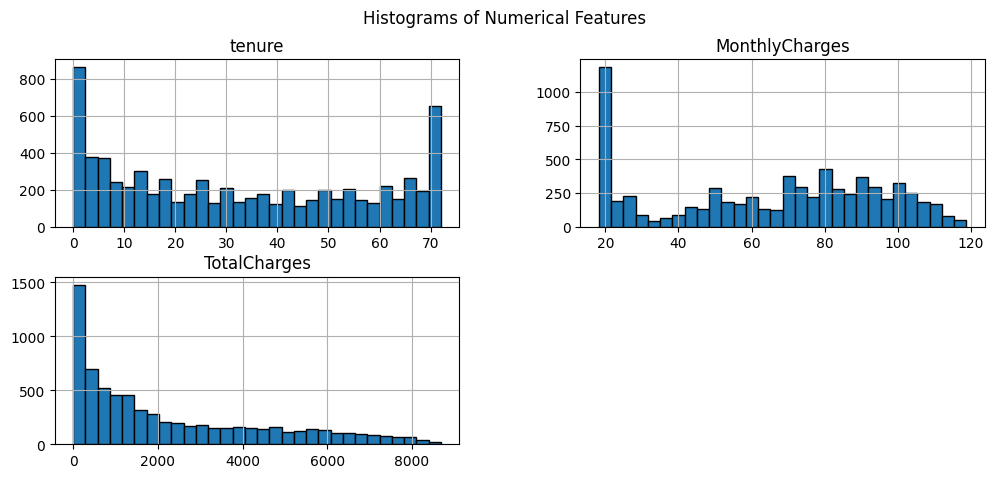

In [20]:


# ------------------------------------------------
# 2.2: Visual exploration
# ------------------------------------------------
print("\nStep 2.2: Generating plots...")

# --- Histogram of numerical variables
df[['tenure','MonthlyCharges','TotalCharges']].hist(
    bins=30, figsize=(12,5), edgecolor='black'
)
plt.suptitle("Histograms of Numerical Features")
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_7660\61627171.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn', data=df, palette="Set2")


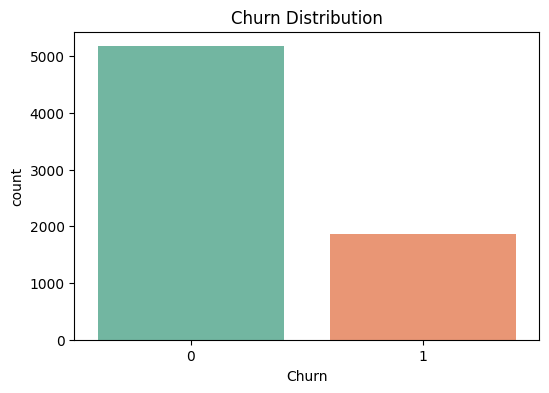

In [21]:

# --- Churn countplot
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df, palette="Set2")
plt.title("Churn Distribution")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14516\2538437424.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_14516\2538437424.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_14516\2538437424.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y=col, data=df, palette="Set2")


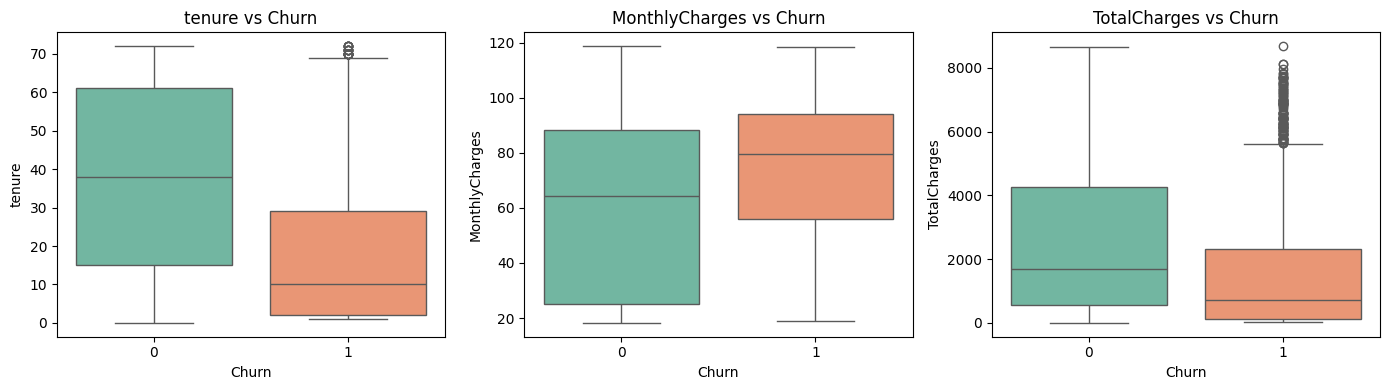

In [39]:

# --- Boxplots: numerical vs Churn
plt.figure(figsize=(14,4))
for i, col in enumerate(['tenure','MonthlyCharges','TotalCharges'], 1):
    plt.subplot(1,3,i)
    sns.boxplot(x='Churn', y=col, data=df, palette="Set2")
    plt.title(f"{col} vs Churn")
plt.tight_layout()
plt.show()

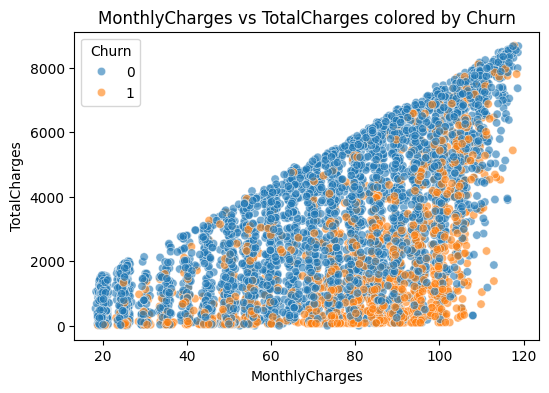

In [40]:
# --- Scatterplot: MonthlyCharges vs TotalCharges
plt.figure(figsize=(6,4))
sns.scatterplot(x='MonthlyCharges', y='TotalCharges', hue='Churn', data=df, alpha=0.6)
plt.title("MonthlyCharges vs TotalCharges colored by Churn")
plt.show()

In [41]:
# ------------------------------------------------
# 2.3: Outlier detection
# ------------------------------------------------
print("\nStep 2.3: Checking outliers (using IQR method)...")

def detect_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    return outliers

for col in ['tenure','MonthlyCharges','TotalCharges']:
    outliers = detect_outliers(col)
    print(f"{col}: {len(outliers)} outliers detected.")


Step 2.3: Checking outliers (using IQR method)...
tenure: 0 outliers detected.
MonthlyCharges: 0 outliers detected.
TotalCharges: 0 outliers detected.



Step 2.4: Correlation analysis...


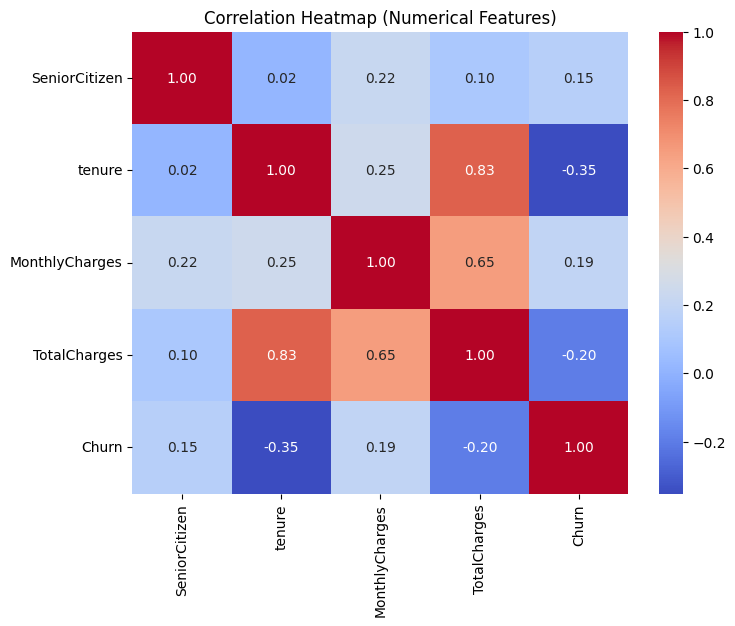

In [42]:

# ------------------------------------------------
# 2.4: Correlation analysis
# ------------------------------------------------
print("\nStep 2.4: Correlation analysis...")

# --- Numerical correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numerical Features)")
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_14516\821745923.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_14516\821745923.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_14516\821745923.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set2")
C:\Users\USER\AppData\Local\Temp\ipykernel_

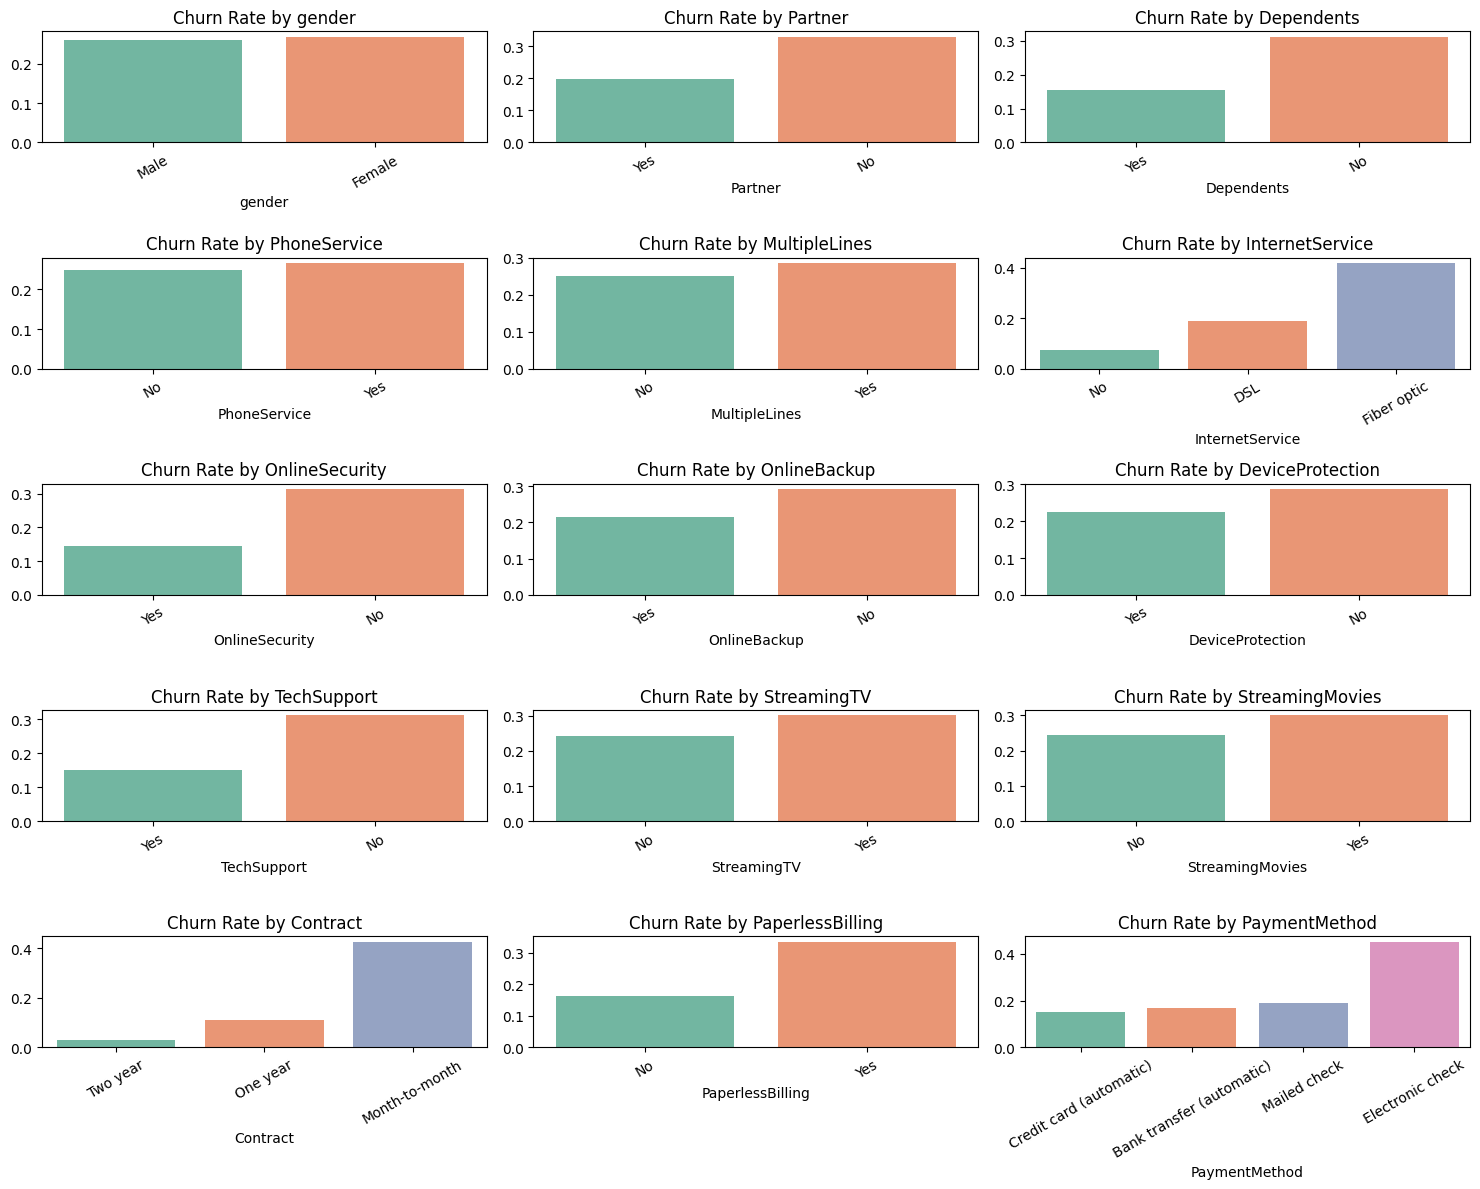

In [43]:



# --- Categorical vs Churn (using % churn rates)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
if categorical_cols:
    plt.figure(figsize=(15, 12))
    for i, col in enumerate(categorical_cols, 1):
        plt.subplot((len(categorical_cols)+2)//3, 3, i)
        churn_rate = df.groupby(col)['Churn'].mean().sort_values()
        sns.barplot(x=churn_rate.index, y=churn_rate.values, palette="Set2")
        plt.title(f"Churn Rate by {col}")
        plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found (already encoded).")


In [46]:
# ================================================================
# PHASE 3: DATA PREPROCESSING
# Tasks 3.1 - 3.3
# ================================================================


# Load cleaned dataset from Phase 1
file_path = "Churning_cleaned.csv"
df = pd.read_csv(file_path)

print("Dataset loaded for preprocessing. Shape:", df.shape)

Dataset loaded for preprocessing. Shape: (7043, 20)


In [47]:
# ------------------------------------------------
# 3.1: Feature Engineering
# ------------------------------------------------
print("\nStep 3.1: Creating new features...")

# Example new feature: Average monthly spend per tenure (if tenure > 0)
df['AvgMonthlySpend'] = df.apply(
    lambda row: row['TotalCharges']/row['tenure'] if row['tenure'] > 0 else row['MonthlyCharges'],
    axis=1
)

print(" - Added 'AvgMonthlySpend' feature.")



Step 3.1: Creating new features...
 - Added 'AvgMonthlySpend' feature.


In [48]:
# ------------------------------------------------
# 3.2: Encoding categorical variables
# ------------------------------------------------
print("\nStep 3.2: Encoding categorical features...")


Step 3.2: Encoding categorical features...


In [49]:
# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object','category']).columns.tolist()
print("Categorical columns:", categorical_cols)

Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [51]:
# Apply OneHotEncoding
encoder = OneHotEncoder(drop='first', sparse_output=False)  # use sparse_output instead of sparse
encoded = encoder.fit_transform(df[categorical_cols])

# Create dataframe for encoded columns
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))


In [52]:

# Create dataframe for encoded columns
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

In [53]:
# Concatenate with original dataset (drop old categorical columns)
df = pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)
print(" - Encoding completed. Shape now:", df.shape)

 - Encoding completed. Shape now: (7043, 25)


In [54]:
# ------------------------------------------------
# 3.3: Normalization / Standardization
# ------------------------------------------------
print("\nStep 3.3: Scaling numerical features...")


Step 3.3: Scaling numerical features...


In [55]:
# Identify numerical features (excluding target 'Churn')
numerical_cols = df.drop(columns=['Churn']).select_dtypes(include=['int64','float64']).columns.tolist()
print("Numerical columns:", numerical_cols)

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

print(" - Scaling completed.")

Numerical columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'AvgMonthlySpend', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
 - Scaling completed.


In [56]:
# ------------------------------------------------
# Final dataset
# ------------------------------------------------
print("\nFinal preprocessed dataset shape:", df.shape)
print("First 5 rows of processed data:")
print(df.head())

# Save preprocessed dataset for next phase
out_path = "Churning_preprocessed.csv"
df.to_csv(out_path, index=False)
print("\n✅ Preprocessed dataset saved to:", out_path)



Final preprocessed dataset shape: (7043, 25)
First 5 rows of processed data:
   SeniorCitizen    tenure  MonthlyCharges  TotalCharges  Churn  \
0      -0.439916 -1.277445       -1.160323     -0.992611      0   
1      -0.439916  0.066327       -0.259629     -0.172165      0   
2      -0.439916 -1.236724       -0.362660     -0.958066      1   
3      -0.439916  0.514251       -0.746535     -0.193672      0   
4      -0.439916 -1.236724        0.197365     -0.938874      1   

   AvgMonthlySpend  gender_Male  Partner_Yes  Dependents_Yes  \
0        -1.156529    -1.009559     1.034530       -0.654012   
1        -0.304408     0.990532    -0.966622       -0.654012   
2        -0.354049     0.990532    -0.966622       -0.654012   
3        -0.790302     0.990532    -0.966622       -0.654012   
4         0.366444    -1.009559    -0.966622       -0.654012   

   PhoneService_Yes  ...  DeviceProtection_Yes  TechSupport_Yes  \
0         -3.054010  ...             -0.723968        -0.639439   


In [79]:
# ================================================================
# PHASE 4: MODEL TRAINING AND EVALUATION + SAVE ARTIFACTS
# ================================================================


# --------------------------
# Step 1: Load cleaned dataset
# --------------------------
# Separate target
y = df["Churn"]

# Identify categorical and numerical columns (features only)
categorical_cols = df.select_dtypes(include="category").columns.tolist()
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]


In [80]:

# --------------------------
# Step 2: Preprocessing
# --------------------------
# One-hot encode categorical variables
encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

In [81]:

# Scale numerical variables
scaler = StandardScaler()
scaled = scaler.fit_transform(df[numerical_cols])
scaled_df = pd.DataFrame(scaled, columns=numerical_cols)

In [82]:
# Combine features
X = pd.concat([encoded_df, scaled_df], axis=1)
y = df["Churn"]


In [83]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [84]:
# --------------------------
# Step 3: Train & Evaluate Models
# --------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob),
        "Model": model,
    }

In [85]:
# --------------------------
# Step 4: Pick Best Model
# --------------------------
best_model_name = max(results, key=lambda x: results[x]["AUC-ROC"])
best_model = results[best_model_name]["Model"]

print("\n✅ Best Model Selected:", best_model_name)
print("Performance Metrics:", results[best_model_name])


✅ Best Model Selected: Gradient Boosting
Performance Metrics: {'Accuracy': 0.7828246983676366, 'Precision': 0.6197183098591549, 'Recall': 0.47058823529411764, 'F1-score': 0.5349544072948328, 'AUC-ROC': 0.8185938670593402, 'Model': GradientBoostingClassifier(random_state=42)}


In [ ]:
# --------------------------
# Step 5: Save artifacts
# --------------------------
joblib.dump(encoder, "encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(model, "best_model.pkl")

print("\n Saved Artifacts:")
print("- best_model.pkl (Best trained model)")
print("- encoder.pkl (OneHotEncoder)")
print("- scaler.pkl (StandardScaler)")



💾 Saved Artifacts:
- best_model.pkl (Best trained model)
- encoder.pkl (OneHotEncoder)
- scaler.pkl (StandardScaler)


In [89]:

# Load training data
df = pd.read_csv("Churning_cleaned.csv")

In [90]:

categorical_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService",
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

for col in categorical_cols:
    df[col] = df[col].astype(str)

In [92]:


# Target
y = df["Churn"].map({"Yes":1, "No":0})




In [96]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler



In [100]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Fit encoder (categorical columns)
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(df[categorical_cols])  # fit on categorical columns

# Fit scaler (numerical columns)
scaler = StandardScaler()
scaler.fit(df[numerical_cols])  # fit on numerical columns




,copy,True
,with_mean,True
,with_std,True


In [98]:
 #2️⃣ Fit the scaler (numerical columns)
scaler = StandardScaler()
scaler.fit(df[numerical_cols])  # fit on numerical columns



,copy,True
,with_mean,True
,with_std,True


In [94]:

scaler = StandardScaler()
scaler.fit(df[numerical_cols])

,copy,True
,with_mean,True
,with_std,True


In [101]:
import joblib
joblib.dump(encoder, "encoder.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']

In [ ]:



# 2️⃣ Prepare features
X_cat_encoded = encoder.transform(df[categorical_cols])
X_num_scaled = scaler.transform(df[numerical_cols])
X_final = np.hstack((X_cat_encoded, X_num_scaled))

# 3️⃣ Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_final, y)

# 4️⃣ Save all fitted artifacts
joblib.dump(encoder, "encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(model, "best_model.pkl")

print("✅ Artifacts saved successfully! Fitted encoder and scaler.")


In [ ]:
# ==================================
# Load cleaned training data
# ==================================
df = pd.read_csv("Churning_cleaned.csv")

if df.shape[0] == 0:
    raise ValueError("The CSV is empty! Please check Churning_cleaned.csv")

# ==================================
# Define columns
# ==================================
categorical_cols = [
    "gender", "SeniorCitizen", "Partner", "Dependents", "PhoneService",
    "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies",
    "Contract", "PaperlessBilling", "PaymentMethod"
]
numerical_cols = ["tenure", "MonthlyCharges", "TotalCharges"]

# ==================================
# Clean categorical columns
# ==================================
for col in categorical_cols:
    if col not in df.columns:
        raise ValueError(f"Missing categorical column: {col}")
    df[col] = df[col].astype(str).str.strip()  # Remove extra spaces
    df[col] = df[col].replace("", "Unknown")   # Fill empty strings

# ==================================
# Clean numerical columns
# ==================================
for col in numerical_cols:
    if col not in df.columns:
        raise ValueError(f"Missing numerical column: {col}")
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

# ==================================
# Encode target
# ==================================
if "Churn" not in df.columns:
    raise ValueError("Missing target column: Churn")
y = df["Churn"].map({"Yes": 1, "No": 0})
if y.isna().any():
    y = y.fillna(0)  # default to 0 if NaN

# ==================================
# Split features
# ==================================
X_cat = df[categorical_cols]
X_num = df[numerical_cols]

if X_cat.shape[0] == 0:
    raise ValueError("No rows available for categorical features!")

# ==================================
# Fit encoder and scaler
# ==================================
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
encoder.fit(X_cat)

scaler = StandardScaler()
scaler.fit(X_num)

# ==================================
# Transform features
# ==================================
X_cat_encoded = encoder.transform(X_cat)
X_num_scaled = scaler.transform(X_num)
X_final = np.hstack((X_cat_encoded, X_num_scaled))

# ==================================
# Train RandomForest model
# ==================================
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_final, y)

# ==================================
# Save artifacts
# ==================================
joblib.dump(encoder, "encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(model, "best_model.pkl")

print("✅ Artifacts saved successfully!")


✅ Artifacts saved successfully!


In [87]:
# ================================================================
# PHASE 5: MODEL COMPARISON
# ================================================================



# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

# Store results
results = []

In [67]:


# Train and evaluate each model
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append([name, acc, prec, rec, f1])


In [68]:

# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-score"])
print("📊 Model Comparison:\n")
print(results_df)

📊 Model Comparison:

                 Model  Accuracy  Precision    Recall  F1-score
0  Logistic Regression  0.807665   0.660436  0.566845  0.610072
1        Decision Tree  0.725337   0.483117  0.497326  0.490119
2        Random Forest  0.787793   0.624585  0.502674  0.557037
3    Gradient Boosting  0.794180   0.648936  0.489305  0.557927


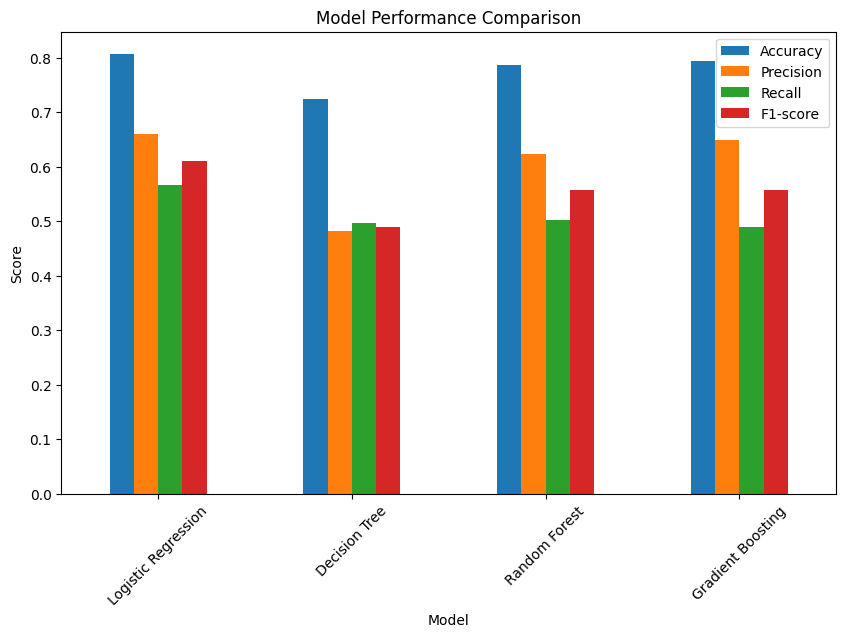

In [69]:


# Optional: visualize comparison
import matplotlib.pyplot as plt

results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-score"]].plot(kind="bar", figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()


In [70]:

# Assume best model is Random Forest (replace with LogisticRegression if needed)
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [71]:
# Predictions for interpretation
y_pred = best_model.predict(X_test)

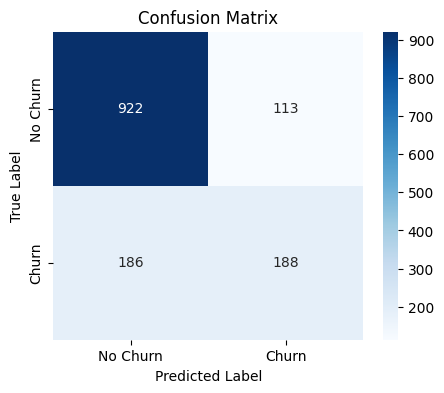


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.50      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [75]:


# -------------------------
# Confusion Matrix Heatmap
# -------------------------
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
